# MNIST softmax

* MNIST data를 가지고 softmax classifier를 만들어보자.
  * [참고 소스: mnist_softmax.py in verion 1.4](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_softmax.py)

### Import modules

In [1]:
"""A very simple MNIST classifier.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/beginners in version 1.4
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_labels = np.asarray(test_labels, dtype=np.int32)

In [3]:
print(train_data.shape)

(60000, 784)


### Show the MNIST

label = 0


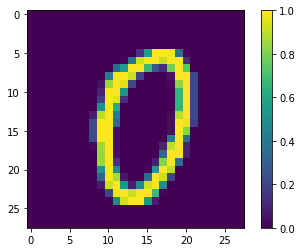

In [4]:
index = 1000
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### Create the model

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.get_variable(name='weights', shape=[784, 10],
                    initializer=tf.zeros_initializer)
b = tf.get_variable(name='bias', shape=[10],
                    initializer=tf.zeros_initializer)
y_pred = tf.matmul(x, W) + b

### Define loss and optimizer

* [`tf.nn.softmax_cross_entropy_with_logits_v2`](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2)
* [`tf.losses.softmax_cross_entropy`](https://www.tensorflow.org/api_docs/python/tf/losses/softmax_cross_entropy)

In [6]:
y = tf.placeholder(tf.int32, [None])
y_one_hot = tf.one_hot(y, depth=10)
# The raw formulation of cross-entropy,
#
#   tf.reduce_mean(-tf.reduce_sum(y * tf.log(tf.nn.softmax(y_pred)),
#                                 reduction_indices=[1]))
#
# can be numerically unstable.
#
# So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
# outputs of 'y', and then average across the batch.
#cross_entropy = tf.reduce_mean(
#                    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_one_hot, logits=y_pred))
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot,
                                                logits=y_pred)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### `tf.Session()` and train

In [7]:
np.random.seed(219)

batch_size = 32
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# Train
max_epochs = 10
loss_history = []
num_batches_per_epoch = int(len(train_data) / batch_size)
start_time = time.time()
for epoch in range(max_epochs):
  shuffle_index = np.random.permutation(len(train_data))
  for step in range(num_batches_per_epoch):
    batch_xs = train_data[shuffle_index[step*batch_size:(step+1)*batch_size]]
    batch_ys = train_labels[shuffle_index[step*batch_size:(step+1)*batch_size]]
    _, loss = sess.run([train_step, cross_entropy],
                       feed_dict={x: batch_xs, y: batch_ys})
    loss_history.append(loss)

    if (step+1) % 100 == 0:
      clear_output(wait=True)
      print("epochs: %d, step: %d, loss: %g" % (epoch, step+1, loss))
    
print('training done!')
print("Elapsed time: {}".format(time.time() - start_time))

epochs: 9, step: 1800, loss: 0.594411
training done!
Elapsed time: 17.130879163742065


### Plot the loss funtion

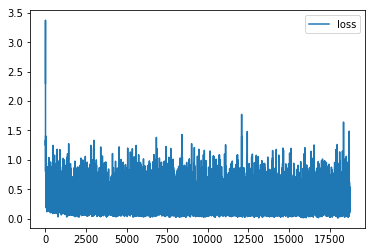

In [8]:
plt.plot(loss_history, label='loss')
plt.legend()
plt.show()

### Test trained model

* test accuracy: 0.9175 for 1 epochs (1.81 sec)
* test accuracy: 0.9156 for 10 epochs (17.13 sec)

In [9]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: test_data,
                                    y: test_labels}))

0.9156


### Plot test set

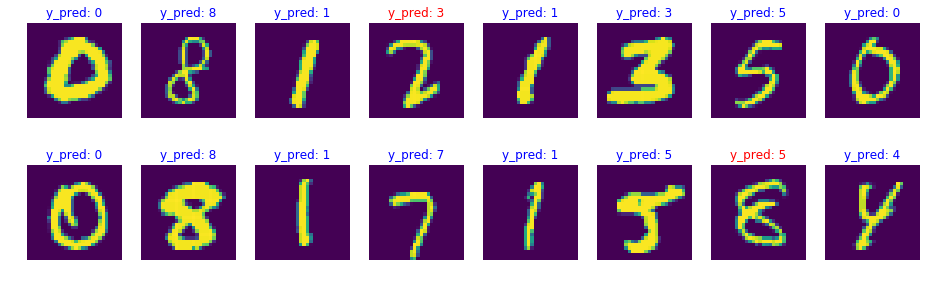

In [10]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = sess.run(y_pred, feed_dict={x: batch_xs})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  #p.imshow(px.reshape(28, 28), cmap='gray')
  p.imshow(px.reshape(28, 28))
  p.axis('off')

## 직접 실습

* 여러가지 hyper-parameter들을 바꿔가면서 accuracy를 높혀보자